In [2]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T

In [6]:
DATA_PATH = '../../data/02_scenes/'

## Vid to Frames

In [7]:
def get_frame_durations(cap, fps):
    """A function that returns the list of durations where to save the frames"""
    
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    
    # use np.arange() to make floating-point steps
    return np.arange(0, clip_duration, 1 / fps)

def split_video(video_file, save_fps=30):
    
    # read in video   
    cap = cv2.VideoCapture(video_file)
    # get video FPS
    fps = min(cap.get(cv2.CAP_PROP_FPS), save_fps)

    # get the list of duration spots to save
    saving_frames_durations = get_frame_durations(cap, fps)
    
    # start the loop
    frames = []
    count = 0
    while True:
        is_read, frame = cap.read()
        if is_read:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            break
        """if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1"""
    return frames

In [8]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

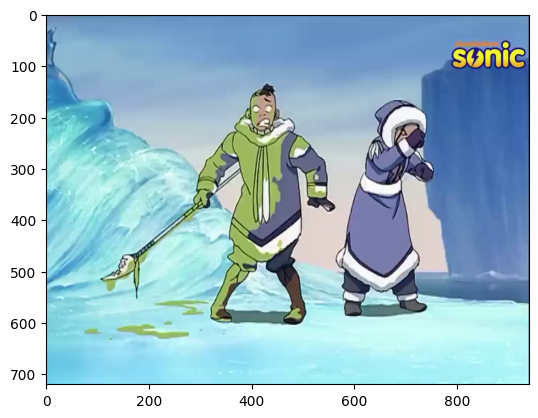

In [9]:
test_frame = frames[0]
plt.imshow(test_frame)

## Mask RCNN Model

In [77]:
def background_segmentation_loader():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights = "DEFAULT")
    model.eval()

    transform = T.ToTensor()
    
    def create_background_mask(frame, mask_conf, cat_conf):
        frame_input = transform(frame)
        with torch.no_grad():
            pred = model([frame_input])

        masks = pred[0]["masks"]
        labels = pred[0]['labels']
        scores = pred[0]['scores']

        background_mask = np.ones(masks[0,0].shape).astype("uint8")
        for i in np.where(scores>cat_conf)[0]:
            inv_obj_mask = (masks[i,0]<=mask_conf).numpy().astype("uint8")
            background_mask = np.all([background_mask,inv_obj_mask],axis=0) 

        return background_mask

    def get_background(frame, mask_conf=0.4, cat_conf=0.7):
        mask = create_background_mask(frame, mask_conf, cat_conf).astype('uint8')
        bg = cv2.bitwise_and(frame , frame , mask = mask)
        return bg
    
    return get_background

In [78]:
segmenter = background_segmentation_loader()

In [79]:
test_frame_background = segmenter(test_frame)

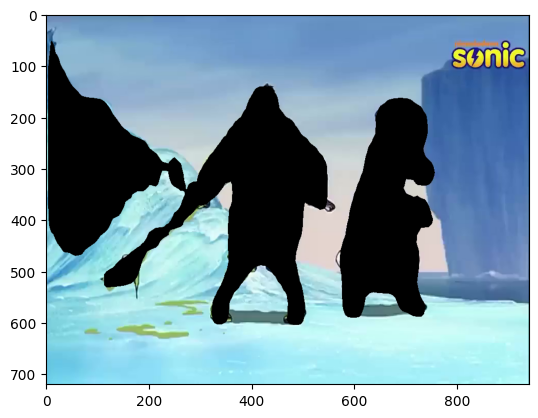

In [80]:
plt.imshow(test_frame_background,'gray')